# Person detection
### set paths

In [1]:
import sys
sys.path.append("../") # go to parent dir

In [2]:
import os
import glob
import argparse
import pickle
import cv2
import numpy as np
from Yolo_v2_pytorch.src.utils import *
from Yolo_v2_pytorch.src.yolo_net import Yolo
from PIL import Image
import time
import matplotlib.pyplot as plt

MissOh_CLASSES = ['person']

In [3]:
def get_args():
    parser = argparse.ArgumentParser(
        "You Only Look Once: Unified, Real-Time Object Detection")
    parser.add_argument("--image_size",
                        type=int, default=448,
                        help="The common width and height for all images")
    parser.add_argument("--conf_threshold",
                        type=float, default=0.35)
    parser.add_argument("--nms_threshold",
                        type=float, default=0.5)
    parser.add_argument("--pre_trained_model_type",
                        type=str, choices=["model", "params"],
                        default="model")
    parser.add_argument("--pre_trained_model_path",
                        type=str,
                        default="../checkpoint/anotherMissOh.pth")
    parser.add_argument("--data_path_test",
                        type=str,
                        default="../Yolo_v2_pytorch/missoh_test/",
                        help="the root folder of dataset")
    args = parser.parse_args(args=[]) # for jupyter 
    return args

In [4]:
opt = get_args()
print(opt)

Namespace(conf_threshold=0.35, data_path_test='../Yolo_v2_pytorch/missoh_test/', image_size=448, nms_threshold=0.5, pre_trained_model_path='../checkpoint/anotherMissOh.pth', pre_trained_model_type='model')


### load a model

In [5]:
global colors
if torch.cuda.is_available():
    if opt.pre_trained_model_type == "model":
        model1 = torch.load(opt.pre_trained_model_path)
    else:
        model1 = Yolo(1)
        model1.load_state_dict(torch.load(opt.pre_trained_model_path))

colors = pickle.load(open("../Yolo_v2_pytorch/src/pallete", "rb"))

model1.eval()
img_list = sorted(glob.glob(os.path.join(opt.data_path_test, '*.jpg')))

print(img_list)

save_dir = '../Yolo_v2_pytorch/anotherMissOh_Test_Result/'

YoloD(
  (stage1_conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage1_conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (stage1_conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1, inplace)
  )
  (stage1_conv4): Sequential(
    (0): Conv2d(128,

### show the person detection results

0
../Yolo_v2_pytorch/anotherMissOh_Test_Result/ + entire_0.png


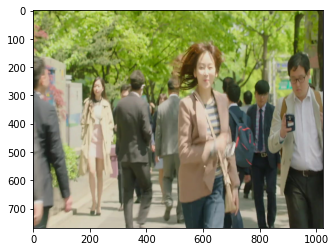

0
../Yolo_v2_pytorch/anotherMissOh_Test_Result/ + entire_1.png


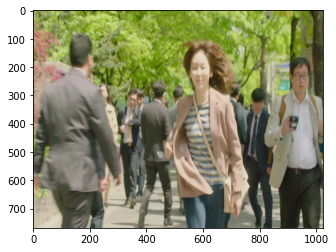

0
../Yolo_v2_pytorch/anotherMissOh_Test_Result/ + entire_2.png


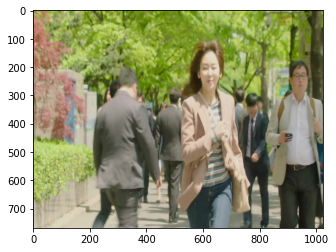

0
../Yolo_v2_pytorch/anotherMissOh_Test_Result/ + entire_3.png


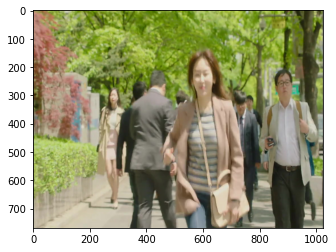

In [11]:
for idx,idx_img in enumerate(img_list):
    image = Image.open(idx_img)
    np_img = np.asarray(image)
    image = cv2.cvtColor(np.float32(np_img), cv2.COLOR_RGB2BGR)
    height, width = image.shape[:2]
    image = cv2.resize(image, (opt.image_size, opt.image_size))
    image = np.transpose(np.array(image, dtype=np.float32), (2, 0, 1))
    image = image[None, :, :, :]
    width_ratio = float(opt.image_size) / width
    height_ratio = float(opt.image_size) / height
    
    data = Variable(torch.FloatTensor(image))

    if torch.cuda.is_available():
        data = data.cuda()

    with torch.no_grad():
        logits = model1(data)
        predictions = post_processing(logits, opt.image_size, MissOh_CLASSES, model1.anchors, opt.conf_threshold,
                                      opt.nms_threshold)
    print(len(predictions))
    output_image = cv2.cvtColor(np.float32(np_img), cv2.COLOR_RGB2BGR)
    if len(predictions) != 0:
        predictions = predictions[0]
        for pred in predictions:
            xmin = int(max(pred[0] / width_ratio, 0))
            ymin = int(max(pred[1] / height_ratio, 0))
            xmax = int(min((pred[0] + pred[2]) / width_ratio, width))
            ymax = int(min((pred[1] + pred[3]) / height_ratio, height))
            color = colors[MissOh_CLASSES.index(pred[5])]

            cv2.rectangle(output_image, (xmin, ymin), (xmax, ymax), color, 2)
            text_size = cv2.getTextSize(pred[5] + ' : %.2f' % pred[4], cv2.FONT_HERSHEY_PLAIN, 1, 1)[0]
            cv2.rectangle(output_image, (xmin, ymin), (xmin + text_size[0] + 3, ymin + text_size[1] + 4),
                          color, -1)
            cv2.putText(
                output_image, pred[5] + ' : %.2f' % pred[4],
                (xmin, ymin + text_size[1] + 4), cv2.FONT_HERSHEY_PLAIN, 1,
                (255, 255, 255), 1)
        cv2.imwrite(save_dir + "entire_{}.png".format(idx), output_image)
    
    print("{} + entire_{}.png".format(save_dir, idx))
    output_image = np.uint8(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.imshow(output_image)
    plt.show()